In [ ]:
!nvidia-smi
#from google.colab import drive
#drive.mount('/content/drive')
#!tensorboard --logdir="./content/drive/MyDrive/project/tensorboard"

Sun Dec  5 20:30:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2080    On   | 00000000:01:00.0 Off |                  N/A |
|  0%   40C    P8    12W / 225W |   1278MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Importing Libraries
import os
import torch
import torchvision
from torchvision import io
from skimage.color import rgb2gray,gray2rgb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm 
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random
import torch.optim.lr_scheduler as lr
import csv
from skimage.metrics import structural_similarity as ssim
import math
from scipy import ndimage
from random import randint
import cv2

In [ ]:
# Custom the dataloader for Pytorch
class CustomDataSet(Dataset):

  # Init method to initiatlize basic variables, like image_id, root_directory, Image size etc
  def __init__(self, image_id, mask_id, root_dir,mode='Train'):
    self.image_id = image_id  # Set image id
    self.mask_id = mask_id    # Set mask id
    self.root_dir = root_dir  # Set root directory
    self.mode = mode          # Set mode (Training or Testing)
    self.dataset_path = root_dir + "new_dataset/" # Set the path of dataset
    if (self.mode == "Train"):  # If mode is training, set the appropiate path
      self.mask_path = root_dir + "masks/"
    if (self.mode == "Test"): # If mode is testting, set the appropiate path
      self.mask_path = root_dir + "test_mask/"
    self.size = 512         # Set image size (Width = Height = 512)

  # Returns the length of the dataset
  def __len__(self):
    return len(self.image_id)

  # Returns a batch of the dataset
  def __getitem__(self, index):
    image_name = self.image_id[index] # Fetch the index of the image
    image_path = os.path.join(self.dataset_path, image_name) # Concatenate and form a full path
    img = io.read_image(image_path)   # Read the image from the directory
    img = transforms.functional.resize(img, (self.size, self.size)) # Resize the image to 512x512 size
    img = img.expand(3, self.size, self.size) # Making sure the image has 3 channels
    
    mask_name = self.mask_id[index]   # Fetch the index of the mask
    mask_path = os.path.join(self.mask_path, mask_name) # Concatenate and form a full path
    
    # change mask for test masks
    if (self.mode == "Test"):
      mask = io.read_image(mask_path)       # Read the mask from the directory
      mask = torch.where(mask > 102, 0, 255) # Binarize the mask
      mask = mask.to(torch.uint8).   # Convert to unsigned integer 8 bit

    if (self.mode == "Train"):
      mask = cv2.imread(mask_path, 0)
      mask = np.where(mask < 102, 0, 255)
        
      # invert mask for dilation purpose and revert it back later
      mask = np.where(mask==255,0,255)
    
      # add random dilation to train masks
      dilateion_value = randint(9, 49)
      kernel = np.ones((3,3),np.uint8)
      mask = cv2.dilate(mask.astype(float), kernel, iterations = dilateion_value)
      
      # revert mask back to original format
      mask = np.where(mask==0,255,0)   
      mask = torch.reshape(torch.Tensor(mask).to(torch.uint8), (1, mask.shape[0], mask.shape[1])) # reshaping the mask


    mask = transforms.functional.resize(mask, (self.size, self.size)) # Resizing the mask
    mask = mask.expand(3, self.size, self.size) # Making sure the mask has 3 channels

    img = img.to(torch.long)    # Convert to long datatype
    img_holes = torch.where(mask == 0, 255, img)    # Forming the holes on the input image based on the masks
    img = img.to(torch.uint8)                 # Converting the datatype to unsigned interger 8 bit
    img_holes = img_holes.to(torch.uint8) # Converting the datatype to unsigned interger 8 bit

    return img, mask, img_holes         # Finally returns original Image, Mask and Image with holes

In [ ]:
root_dir = "./content/drive/MyDrive/project/" # The root directory
img_id = os.listdir(root_dir + "new_dataset") # To load image names from the directory
mask_trainf = os.listdir(root_dir + "masks") # Load mask names from directory
mask_testf = os.listdir(root_dir + "test_mask") # Load test mask names from directory

random.seed(42) # Seeding to reproduce the same result

### Tune Parameters ###
batch_size = 4
learning_rate = 1e-4
num_epoch = 20
log_interval = 20   # number of steps after which to print train losss to console
split_ratio = 0.2   # Splitting ratio used to split dataset into training and testing
model_log_interval = 10  # save model state after model_log_interval steps of training
model_name = "full_dataset"  # unique identifier for saving models
load_mod = False  # set previously saved model as the current model
img_log = 10  # number of steps after which images should be logged to tensorboard
total_imgs = 1000  # number of train + test images used 


## Hyper parameter used for MobileNet_V2 encoder ##
#batch_size = 16
#learning_rate = 3e-4
#num_epoch = 5000
#log_interval = 5
#split_ratio = 0.8
#criterion = nn.BCEWithLogitsLoss() 

# Creatinf Hyperparameter dictionary
hparams = {"batch size": batch_size,
          "learning rate": learning_rate,
          "epochs": num_epoch,
          "loss log step": log_interval,
          "train test split": split_ratio,
          "model log step": model_log_interval,
          "model description": model_name,
          "image log step": img_log,
          "total num images": total_imgs,
          "notes": "custom partial conv"}


# write hyperparameters to a csv file
with open(root_dir + "hparams.csv", 'w') as f:
    for key in hparams.keys():
        f.write("%s,%s\n"%(key,hparams[key]))

# Randomly sampling the  the images from the dataset
img_id = random.sample(img_id, total_imgs)
train_id, test_id = train_test_split(img_id, test_size=split_ratio, random_state=42) # Splitting the datset

mask_train = random.sample(mask_trainf, len(train_id)). # Randomly sample train masks
mask_test = random.sample(mask_testf, len(test_id))    # Randomly sample test masks
#mask_test = random.sample(mask_trainf, len(test_id))  #Uncomment to use train mask in testing mode i.e. when model is in eval mode

train_dataset = CustomDataSet(image_id = train_id, mask_id = mask_train, root_dir = root_dir,mode="Train") # Creating Training Dataset
test_dataset = CustomDataSet(image_id = test_id, mask_id = mask_test, root_dir = root_dir,mode="Test")    # Creating Testing Dataset
#test_dataset = CustomDataSet(image_id = test_id, mask_id = mask_test, root_dir = root_dir,mode="Train")  # Uncomment to load Testing Dataset with training masks

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Creating Train loader with shuffle as True
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)  # Creating Test loader with shuffle as True

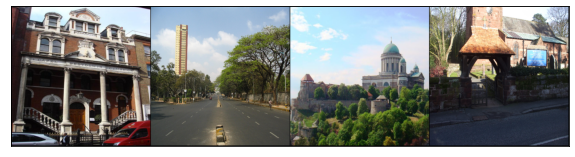

In [ ]:
(data, masks, img_holes) = next(iter(train_loader)) # Load a sample from Train loader
grid_data = torchvision.utils.make_grid(data) # Display the image in grid form

# Function which displays the image
def show(imgs):
  if not isinstance(imgs, list):
    imgs = [imgs]
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=[10,10])
  for i, img in enumerate(imgs):
    img = img.detach()
    img = transforms.functional.to_pil_image(img)
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(grid_data)

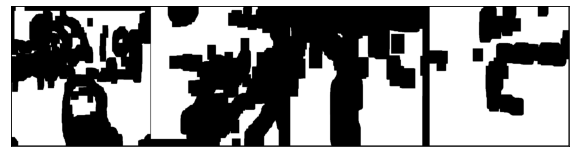

In [ ]:
# Displaying masks
grid_masks = torchvision.utils.make_grid(masks)
show(grid_masks)

In [1]:
# Displaying Images with Holes
grid_holes = torchvision.utils.make_grid(img_holes)
show(grid_holes)

NameError: ignored

In [ ]:
##### partial convolution layer #####
###############################################################################
# BSD 3-Clause License
#
# Copyright (c) 2018, NVIDIA CORPORATION. All rights reserved.
#
# Author & Contact: Guilin Liu (guilinl@nvidia.com)
###############################################################################

from torch import nn, cuda
from torch.autograd import Variable

# Class for Partial 2d Convoltuion
class PartialConv2d(nn.Conv2d):
    # Init method
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False  

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PartialConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])
            
        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    # Forward Pass
    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in
                        
                self.update_mask = self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)


        if self.return_mask:
            return output, self.update_mask
        else:
            return output

In [ ]:
# Custom Part model
class customPart(nn.Module):
  def __init__(self):
    super(customPart, self).__init__()

    # encoder 
    self.partialConv1 = PartialConv2d(3, 32, 3, 2, 1, return_mask=True)
    self.partialConv2 = PartialConv2d(32, 64, 3, 2, 1, return_mask=True)
    self.partialConv3 = PartialConv2d(64, 128, 3, 2, 1, return_mask=True)
    self.partialConv4 = PartialConv2d(128, 256, 3, 2, 1, return_mask=True)
    self.partialConv5 = PartialConv2d(256, 512, 3, 2, 1, return_mask=True)

    # decoder
    self.upsample1 = nn.Upsample(scale_factor=2)
    self.partialConv6 = PartialConv2d(512, 256, 3, 1, 1, return_mask=False)
    self.upsample2 = nn.Upsample(scale_factor=2)
    self.partialConv7 = PartialConv2d(256, 128, 3, 1, 1, return_mask=False)
    self.upsample3 = nn.Upsample(scale_factor=2)
    self.partialConv8 = PartialConv2d(128, 64, 3, 1, 1, return_mask=False)
    self.upsample4 = nn.Upsample(scale_factor=2)
    self.partialConv9 = PartialConv2d(64, 32, 3, 1, 1, return_mask=False)
    self.upsample5 = nn.Upsample(scale_factor=2)
    self.partialConv10 = PartialConv2d(32, 3, 3, 1, 1, return_mask=False)
    

  def forward(self, x, m):
    m = m[:,0:1,:,:]

    (x, m1) = self.partialConv1(x, m)
    x1 = F.relu(x)
    (x, m2) = self.partialConv2(x1, m1)
    x2 = F.relu(x)
    (x, m3) = self.partialConv3(x2, m2)
    x3 = F.relu(x)
    (x, m4) = self.partialConv4(x3, m3)
    x4 = F.relu(x)
    (x, m5) = self.partialConv5(x4, m4)
    x = F.relu(x)
    
    x = self.upsample1(x)

    if torch.count_nonzero(m4) < torch.numel(m4):
        m4 = torch.where(m4 == 0, 1.0, 0.0)
    
    x = self.partialConv6(x, m4)
    x = F.relu(x)
    x = self.upsample2(x)
    
    if torch.count_nonzero(m3) < torch.numel(m3):
        m3 = torch.where(m3 == 0, 1.0, 0.0)
    
    x = self.partialConv7(x, m3)
    x = F.relu(x)
    x = self.upsample3(x)
    
    if torch.count_nonzero(m2) < torch.numel(m2):
        m2 = torch.where(m2 == 0, 1.0, 0.0)
    
    x = self.partialConv8(x, m2)
    x = F.relu(x)
    x = self.upsample4(x)
    
    if torch.count_nonzero(m1) < torch.numel(m1):
        m1 = torch.where(m1 == 0, 1.0, 0.0)
    
    x = self.partialConv9(x, m1)
    x = F.relu(x)
    x = self.upsample5(x)

    if torch.count_nonzero(m) < torch.numel(m):
        m = torch.where(m == 0, 1.0, 0.0)
        
    output = self.partialConv10(x, m)
    
    return output

# Partial Conv Model
class partialConv(nn.Module):
  def __init__(self):
    super(partialConv, self).__init__()

    # encoder 
    self.partialConv1 = PartialConv2d(3, 32, 3, 2, 1, return_mask=True)
    self.partialConv2 = PartialConv2d(32, 64, 3, 2, 1, return_mask=True)
    self.partialConv3 = PartialConv2d(64, 128, 3, 2, 1, return_mask=True)
    self.partialConv4 = PartialConv2d(128, 256, 3, 2, 1, return_mask=True)
    self.partialConv5 = PartialConv2d(256, 512, 3, 2, 1, return_mask=True)

    # decoder
    self.upsample1 = nn.Upsample(scale_factor=2)
    self.conv6 = nn.Conv2d(512, 256, 3, 1, 1)
    self.upsample2 = nn.Upsample(scale_factor=2)
    self.conv7 = nn.Conv2d(512, 128, 3, 1, 1)
    self.upsample3 = nn.Upsample(scale_factor=2)
    self.conv8 = nn.Conv2d(256, 64, 3, 1, 1)
    self.upsample4 = nn.Upsample(scale_factor=2)
    self.conv9 = nn.Conv2d(128, 32, 3, 1, 1)
    self.upsample5 = nn.Upsample(scale_factor=2)
    self.conv10 = nn.Conv2d(64, 3, 3, 1, 1)
    

  def forward(self, x, m):
    m = m[:,0:1,:,:]

    (x, m1) = self.partialConv1(x, m)
    x1 = F.relu(x)
    (x, m2) = self.partialConv2(x1, m1)
    x2 = F.relu(x)
    (x, m3) = self.partialConv3(x2, m2)
    x3 = F.relu(x)
    (x, m4) = self.partialConv4(x3, m3)
    x4 = F.relu(x)
    (x, m5) = self.partialConv5(x4, m4)
    x = F.relu(x)
    
    x = self.upsample1(x)
    x = self.conv6(x)
    x = F.relu(x)
    x = torch.cat([x4, x], 1)
    x = self.upsample2(x)
    x = self.conv7(x)
    x = F.relu(x)
    x = torch.cat([x3, x], 1)
    x = self.upsample3(x)
    x = self.conv8(x)
    x = F.relu(x)
    x = torch.cat([x2, x], 1)
    x = self.upsample4(x)
    x = self.conv9(x)
    x = F.relu(x)
    x = torch.cat([x1, x], 1)
    x = self.upsample5(x)
    output = self.conv10(x)
    
    return output

# Baseline with Skip model
class baselineSkip(nn.Module):
  def __init__(self):
    super(baselineSkip, self).__init__()

    # encoder 
    self.conv1 = nn.Conv2d(3, 32, 3, 2, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
    self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
    self.conv4 = nn.Conv2d(128, 256, 3, 2, 1)
    self.conv5 = nn.Conv2d(256, 512, 3, 2, 1)

    # decoder
    self.upsample1 = nn.Upsample(scale_factor=2)
    self.conv6 = nn.Conv2d(512, 256, 3, 1, 1)
    self.upsample2 = nn.Upsample(scale_factor=2)
    self.conv7 = nn.Conv2d(512, 128, 3, 1, 1)
    self.upsample3 = nn.Upsample(scale_factor=2)
    self.conv8 = nn.Conv2d(256, 64, 3, 1, 1)
    self.upsample4 = nn.Upsample(scale_factor=2)
    self.conv9 = nn.Conv2d(128, 32, 3, 1, 1)
    self.upsample5 = nn.Upsample(scale_factor=2)
    self.conv10 = nn.Conv2d(64, 3, 3, 1, 1)
    

  def forward(self, x):
    x = self.conv1(x)
    x1 = F.relu(x)
    x = self.conv2(x1)
    x2 = F.relu(x)
    x = self.conv3(x2)
    x3 = F.relu(x)
    x = self.conv4(x3)
    x4 = F.relu(x)
    x = self.conv5(x4)
    x = F.relu(x)
    
    x = self.upsample1(x)
    x = self.conv6(x)
    x = F.relu(x)
    x = torch.cat([x4, x], 1)
    x = self.upsample2(x)
    x = self.conv7(x)
    x = F.relu(x)
    x = torch.cat([x3, x], 1)
    x = self.upsample3(x)
    x = self.conv8(x)
    x = F.relu(x)
    x = torch.cat([x2, x], 1)
    x = self.upsample4(x)
    x = self.conv9(x)
    x = F.relu(x)
    x = torch.cat([x1, x], 1)
    x = self.upsample5(x)
    output = self.conv10(x)

    return output

class baseline(nn.Module):
  def __init__(self):
    super(baseline, self).__init__()

    # encoder 
    self.conv1 = nn.Conv2d(3, 32, 3, 2, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
    self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
    self.conv4 = nn.Conv2d(128, 256, 3, 2, 1)
    self.conv5 = nn.Conv2d(256, 512, 3, 2, 1)

    # decoder
    self.upsample1 = nn.Upsample(scale_factor=2)
    self.conv6 = nn.Conv2d(512, 256, 3, 1, 1)
    self.upsample2 = nn.Upsample(scale_factor=2)
    self.conv7 = nn.Conv2d(512, 128, 3, 1, 1)
    self.upsample3 = nn.Upsample(scale_factor=2)
    self.conv8 = nn.Conv2d(256, 64, 3, 1, 1)
    self.upsample4 = nn.Upsample(scale_factor=2)
    self.conv9 = nn.Conv2d(128, 32, 3, 1, 1)
    self.upsample5 = nn.Upsample(scale_factor=2)
    self.conv10 = nn.Conv2d(64, 3, 3, 1, 1)
    

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = self.conv5(x)
    x = F.relu(x)
    
    x = self.upsample1(x)
    x = self.conv6(x)
    x = F.relu(x)
    x = self.upsample2(x)
    x = self.conv7(x)
    x = F.relu(x)
    x = self.upsample3(x)
    x = self.conv8(x)
    x = F.relu(x)
    x = self.upsample4(x)
    x = self.conv9(x)
    x = F.relu(x)
    x = self.upsample5(x)
    output = self.conv10(x)

    return output

# Unet Archtecture with MobileNet V2 as the ebcoder
class Mobile_Unet(nn.Module):
    def __init__(self):
        super(Mobile_Unet,self).__init__()
        self.encoder = models.mobilenet_v2(pretrained=True).features[:19] # Slicing the model upto 19 layers
        
        for params in self.encoder.parameters(): # Freezing the weights of the model
            params.required_grad = False

        self.feature_extract = ['0','6','13'] # Layer number from which the features would be used
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1280, out_channels=96, kernel_size=2, stride=2)
        self.up_conv1 = double_conv(192, 96)

        self.up_trans_2 = nn.ConvTranspose2d(in_channels=96, out_channels=32, kernel_size=2, stride=2)
        self.up_conv2 = double_conv(64, 32)

        self.up_trans_3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=4)
        self.up_conv3 = double_conv(64, 32)
        
        self.out_mask = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2, stride=2)

      

    def forward(self, x):
        feature_extract = []

        # Appending the feature layer can be thought as a encoder layer
        for layer_num, layer in enumerate(self.encoder):
            x = layer(x)
            if str(layer_num) in self.feature_extract:
                feature_extract.append(x)
        
        # Decoder layer with concatenation operation
        x1 = self.up_trans_1(x)
        x2 = self.up_conv1(torch.cat([x1, feature_extract[2]], 1))
        x3 = self.up_trans_2(x2)
        x4 = self.up_conv2(torch.cat([x3, feature_extract[1]], 1))
        x5 = self.up_trans_3(x4)
        x6 = self.up_conv3(torch.cat([x5, feature_extract[0]], 1))
        mask = torch.sigmoid(self.out_mask(x6))
        
        return mask

In [ ]:
# Setting tenserboard to log loss and images
#%load_ext tensorboard
#%tensorboard --logdir ./content/drive/MyDrive/project/tensorboard/

# Function defining custom loss
def custom_loss(output, data, mask):
    hole_difference = torch.abs(torch.mul((1 - mask), (output - data)))
    actual_loss = torch.sum(hole_difference)
    num_holes = torch.count_nonzero(hole_difference)
    return (actual_loss/num_holes)
    
# Defining writer for tensorboard
writer = SummaryWriter(root_dir + "tensorboard/")

# Function to save the model
def model_save(model, optimizer, model_name, batch_idx):
  print('saving model....')
  model_path = os.path.join(root_dir + "models/" + model_name +'.pt')
  torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, model_path)

# Function to train the model
def train(model, train_loader, device, epoch, log_interval, model_name, step):
    
  model.train() # Set model in training mode
  cumulative_loss = 0

  for batch_idx, (data,mask,img_holes) in enumerate(train_loader):
    data, mask, img_holes = data.to(device), mask.to(device), img_holes.to(device) # Set elemets to cuda if available
    data, mask, img_holes = data/255.0, mask/255.0, img_holes/255.0 # Normalizing the image's pixel value beteen 0.0 - 1.0. 

    optimizer.zero_grad()           # Setting the gradients to zero
    output = model(img_holes, mask)   # pass the ground truth and the mask (image with holes) to the model

    ## Loss function for MobileNet_V2 encoder
    # loss1 = criterion(output,data.float()) 
    # loss2 = F.l1_loss(output,data.float())
    # loss = 0.6*(loss1) + 0.4*(loss2) 

    loss = custom_loss(output, data, mask)      # Passing through loss
    
    cumulative_loss += loss         # Accumulating the loss
    loss.backward()                 # Backward pass
    optimizer.step()                # Updating the optimizer

    # Logging elemets
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
    step = step + 1
    
  writer.add_scalars("loss", {'Trainig loss':(cumulative_loss/batch_idx)}, epoch)
    
  # log model checkpoints
  if epoch % model_log_interval == 0:
    model_save(model, optimizer, model_name, batch_idx)

  if epoch % img_log == 0:
    grid_img = torchvision.utils.make_grid(data)
    writer.add_image('Training Input_Image', grid_img, global_step=epoch)
    
    output = torch.where(mask == 0, output, data)
    grid_mask = torchvision.utils.make_grid(output)
    writer.add_image('Training Predicted_Image', grid_mask, global_step=epoch)

    grid_amask = torchvision.utils.make_grid(img_holes)
    writer.add_image('Training Images_with_holes', grid_amask, global_step=epoch)

  return step



# calculate quantitative metrics on test data
def quant_metrics(output, data):
  output, data = output*255.0, data*255.0

  # calculate L1 loss on normalized images
  L1_loss = F.l1_loss(output, data)  # sum up batch loss

  output = torch.reshape(output, (output.shape[0], output.shape[2],
                                 output.shape[3], output.shape[1])).cpu().detach().numpy()
  data = torch.reshape(data, (data.shape[0], data.shape[2],
                                 data.shape[3], data.shape[1])).cpu().detach().numpy()
  
  # calculate PSNR 
  difference_imgs = data - output
  mse = np.mean(difference_imgs**2)
  if mse == 0:
    return 100
  PIXEL_MAX = 255.0
  PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
  
  # calculate SSIM
  SSIM = 0
  for i in range(output.shape[0]):
    SSIM = SSIM + ssim(data[i,:,:,:], output[i,:,:,:], multichannel=True)
  SSIM = SSIM/(i+1)
    
  return L1_loss, PSNR, SSIM
  
  
# Function to test the model
def test(model, test_loader, device, epoch, step):
  model.eval(). # Setting the model to evaluation mode
  test_loss = 0
    
  with torch.no_grad():  # Turning off the gradient
    for batch_idx, (data,mask,img_holes) in enumerate(test_loader):
      data, mask, img_holes = data.to(device), mask.to(device), img_holes.to(device)  # Set elemets to cuda if available
      data, mask, img_holes = data/255.0, mask/255.0, img_holes/255.0 # Normalizing the image's pixel value beteen 0.0 - 1.0. 
      output = model(img_holes, mask) # Passing the image and the mask(image with holes) to the mode;
      test_loss += custom_loss(output, data, mask)
        
    if epoch % img_log == 0:
      grid_img = torchvision.utils.make_grid(data)
      writer.add_image('Testing Input_Image',grid_img, global_step=epoch)
        
      output = torch.where(mask == 0, output, data)
      grid_mask = torchvision.utils.make_grid(output)
      writer.add_image('Testing Predicted_image',grid_mask, global_step=epoch)

      grid_amask = torchvision.utils.make_grid(img_holes)
      writer.add_image('Testing Image_with_holes',grid_amask, global_step=epoch)
    
    # calculate quantitative metrics
    L1_loss, PSNR, SSIM = quant_metrics(output, data)
    
    #Tensorboard
    writer.add_scalars("loss", {'Testing loss':(test_loss/batch_idx)}, epoch)
    writer.add_scalar('Error Metric/l1 loss', L1_loss, step)
    writer.add_scalar('Error Metric/psnr', PSNR, step)
    writer.add_scalar('Error Metric/ssim', SSIM, step)
    
  print('\nTest set: Average loss: {:.4f}'.format(test_loss))
  

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = customPart().to(device)
print(model)

# write model description to text file
with open(root_dir + 'model.txt', 'w') as f:
  f.write(str(model))

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# write optimizer description in text file
with open(root_dir + 'optimizer.txt', 'w') as f:
  f.write(str(optimizer))

if (load_mod == True):
  print('loading model .......')
  checkpoint = torch.load(root_dir + "models/" + model_name + '.pt')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

step = 0
for epoch in range(1, num_epoch+1, 1):
  step = train(model, train_loader, device, epoch, log_interval, model_name, step)
  test(model, test_loader, device, epoch, step)

customPart(
  (partialConv1): PartialConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (partialConv2): PartialConv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (partialConv3): PartialConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (partialConv4): PartialConv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (partialConv5): PartialConv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (upsample1): Upsample(scale_factor=2.0, mode=nearest)
  (partialConv6): PartialConv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample2): Upsample(scale_factor=2.0, mode=nearest)
  (partialConv7): PartialConv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample3): Upsample(scale_factor=2.0, mode=nearest)
  (partialConv8): PartialConv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample4): Upsample(scale_factor=2.0, mode=nearest)
  (partialConv9): PartialCo